# Non-linear analysis - one trial example
---

# Import

In [43]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
# import nilearn as nil
# import nibabel as nib
# from nilearn.connectome import ConnectivityMeasure
import mne
import pickle
from teaspoon.parameter_selection.MI_delay import MI_for_delay
import warnings
from scipy.stats import linregress
from teaspoon.parameter_selection.FNN_n import FNN_n
import seaborn as sns
from tqdm import tqdm
from scipy.stats import gaussian_kde
from scipy.spatial.distance import pdist, squareform


In [30]:
plt.rcParams['text.usetex'] = False


# Utils

In [3]:
# Time-delay embedding of a single time series
def td_embedding(ts: np.ndarray, embedding: int, tau: int):

    min_len = (embedding - 1)*tau + 1

    # Check if embedding is possible
    if len(ts) < min_len:

        print('Data lenght is insufficient, try smaller parameters')
        return
    
    # Set lenght of embedding
    m = len(ts) - min_len + 1

    # Get indexes
    idxs = np.repeat([np.arange(embedding)*tau], m, axis = 0)
    idxs += np.arange(m).reshape((m, 1))

    emb_ts = ts[idxs]

    emb_ts = np.asarray(emb_ts, dtype = np.float64)

    return emb_ts

In [4]:
# To compute the correlation sum

# Euclidean distance
def dist(x: np.ndarray, y: np.ndarray, m_norm = False, m = None):

    d = np.sqrt(np.sum((x - y)**2, axis = 0))

    if m_norm == True and m != None:

        d = d/m

    return d

def distance_matrix(emb_ts: np.ndarray, m_norm = None, m = None):

    N = emb_ts.shape[1]

    dist_matrix = np.full((N,N), 0, dtype = np.float64)

    # Cycle through all different couples of points
    for i in range(0,N):
        for j in range(0,i + 1):

            dij = dist(x = emb_ts[:,i], y = emb_ts[:,j], m_norm = m_norm, m = m)

            dist_matrix[i,j] = dij
            dist_matrix[j,i] = dij

    return dist_matrix

In [ ]:
# Faster distance matrix
def distance_matrix_scipy(emb_ts: np.ndarray, m_norm: bool = False, m: float | None = None) -> np.ndarray:
    X = np.asarray(emb_ts, dtype=np.float64).T  # (N, d)
    D = squareform(pdist(X, metric="euclidean"))
    if m_norm and (m is not None):
        D /= m
    return D


In [5]:
# 1-D function Adymensional Gaussian kernel convolution
def gauss_kernel(function: np.ndarray, x: np.ndarray, scale: float, cutoff: int, order: int):

    i_len = len(function)

    # Create convoluted array
    c_function = np.copy(function)
    c_x = np.copy(x)

    # Create redundant head and tails
    f_tail = np.array([function[0] for i in range(0,cutoff)])
    f_head = np.array([function[-1] for i in range(0,cutoff)])

    x_tail = np.array([x[0]  for i in range(0,cutoff)])
    x_head = np.array([x[-1] for i in range(0,cutoff)])

    function = np.concatenate((f_tail, function, f_head))
    x = np.concatenate((x_tail, x, x_head))

    for i in range(0,i_len):

        vals = np.array([function[j] for j in range(i, 2*cutoff + i + 1)])
        if order == 0:
            ker = np.array([np.exp((x[j]-c_x[i])**2)/(2*(scale**2)) for j in range(i, 2*cutoff + i + 1)])
        elif order == 1:
            print('Order 1 kernel Not yet implemented')
            return

        c_function[i] = np.sum(vals*ker)/np.sum(ker)

    return c_function

In [6]:
# Correlation Sum from a Recurrence Plot
def corr_sum(dist_matrix: np.ndarray, r: float, w: int):

    N = dist_matrix.shape[0]

    if w == 0:

        c = 0
        for i in range(0,N):
            for j in range(0,i):

                if dist_matrix[i,j] < r:

                    c += 1

        csum = (2/(N*(N-1)))*c

    else:

        c = 0
        for i in range(0,N):
            for j in range(0,i):

                if dist_matrix[i,j] < r and (i - j) > w:

                    c += 1

        csum = (2/((N-w)*(N-w-1)))*c

    return csum

In [7]:
# Correlation Exponent computation
def corr_exp(log_csum: list, log_r: list, n_points: int, gauss_filter: bool, scale = None, cutoff = None):

    rlen = len(log_r) - n_points + 1

    ce =  []
    e_ce = []
    n_log_r = []
    for i in range(0,rlen):

        m = np.array([(log_csum[i+j+1] - log_csum[i+j])/(log_r[i+j+1] - log_r[i+j]) for j in range(0,n_points-1)])

        # Get value for error of slope
        with warnings.catch_warnings():
            warnings.simplefilter('ignore')
            results = linregress(x = np.asarray(log_r)[i:i + n_points], y = log_csum[i:i + n_points])

        ce.append(np.asarray(m).mean())
        e_ce.append(results.stderr)

        n_log_r.append(np.mean(np.asarray(log_r)[i:i + n_points]))

    ce = np.asarray(ce)
    e_ce = np.asarray(e_ce)

    n_log_r = np.asarray(n_log_r)

    # Apply Gaussian filtering for smoothing
    if gauss_filter is True:
        if cutoff or scale is None:
            raise ValueError('\'cutoff\' and \'scale\' need to be set for kernel computation')
        else:
            ce = gauss_kernel(function = ce, x = n_log_r, scale = scale, cutoff = cutoff, order = 0)
            e_ce = gauss_kernel(function = e_ce, x = n_log_r, scale = scale, cutoff = cutoff, order = 0)

    return  ce, e_ce

In [8]:
# Spacetime Separation Plot for a single embeddend time series
def sep_plt(dist_matrix: np.ndarray, percentiles: np.ndarray, T: int):

    N = dist_matrix.shape[0]

    n = percentiles.shape[0]

    splt = np.full((n,T), 0, dtype = np.float64)

    # Compose distribution of distances for each relative time distance
    for i in range(0,N):

        dist = []
        for j in range(0, N - i):

            dist.append(dist_matrix[j,i + j])

        if (N - i) > 2*n:

            perc = np.percentile(dist, percentiles)

            splt[:,i] = perc

    return splt

In [9]:
# Recurrence Plot for a single embeddend time series
def rec_plt(dist_matrix: np.ndarray, r: float, T: int):

    N = dist_matrix.shape[0]

    rplt = np.full((T,T), 0, dtype = np.int8)

    # Cycle through all different couples of points
    for i in range(0,N):
        for j in range(0,i + 1):

            # Get value of theta
            if dist_matrix[i,j] < r:
                
                rplt[i,j] = 1
                rplt[j,i] = 1
    np.fill_diagonal(rplt, 0)

    return rplt

In [10]:
# Spacetime Separation Plot for a single embeddend time series
def sep_plt(dist_matrix: np.ndarray, percentiles: np.ndarray, T: int):

    N = dist_matrix.shape[0]

    n = percentiles.shape[0]

    splt = np.full((n,T), 0, dtype = np.float64)

    # Compose distribution of distances for each relative time distance
    for i in range(0,N):

        dist = []
        for j in range(0, N - i):

            dist.append(dist_matrix[j,i + j])

        if (N - i) > 2*n:

            perc = np.percentile(dist, percentiles)

            splt[:,i] = perc

    return splt

In [11]:
# Largest Lyapunov exponent for a single embedded time series [Rosenstein et al.]
def lyap(emb_ts: np.ndarray, lenght: int, m_period: int, sfreq: int, verbose = False):
    """""
    emb_ts: m x time_points
    m_period: theiler window
    """""
    N = len(emb_ts)

    if N < m_period/10:
        print('Embedded data too short compared to average period')
        return

    ds = np.zeros((N,N), dtype = np.float64)

    # Cycle through all different couples of points
    for i in range(0,N):
        for j in range(0,i):
            
            dij = dist(emb_ts[i],emb_ts[j])
            ds[i,j] = dij
            ds[j,i] = dij

    # Construct separations trajectories with embedded data
    lnd = []
    for i, el in enumerate(ds):

        if i < N - lenght:

            # Select only distant points on the trajectory but not too far on the end
            jt = []
            for j in range(0,N):
                if abs(j-i) > m_period and j < N - lenght:
                    jt.append(j)

            if len(jt) != 0:
                # Get nearest neighbour
                d0 = np.min(el[jt])
                j = int(np.argwhere(el == d0))

            # Construct separation data
            for delta in range(0,lenght):
                if len(jt) != 0:
                    lnd.append(np.log(dist(emb_ts[i + delta],emb_ts[j + delta])))
                else:
                    lnd.append(np.nan)

    # Reshape results
    lnd = np.asarray(lnd).reshape((N - lenght ,lenght))

    # Get slope for largest Lyapunov exponent
    x = np.asarray([i for i in range (0,lenght)])

    with warnings.catch_warnings():
        if verbose == False:
            warnings.simplefilter('ignore')
            y = np.nanmean(lnd, axis = 0)*sfreq
        else:
            y = np.nanmean(lnd, axis = 0)*sfreq

    fit = linregress(x,y)

    lyap = fit.slope
    lyap_e = fit.stderr

    return lyap, lyap_e, x, y, fit

In [ ]:
def find_plateaus(y, tol=0.0, min_len=5, use_median=True):
    """
    Find plateaus in a 1D curve y: contiguous segments where the signal is constant
    (within tolerance), i.e. |y[i] - y[i-1]| <= tol.

    Parameters
    ----------
    y : array-like, shape (n,)
        Input signal.
    tol : float, default=0.0
        Tolerance for changes between consecutive samples. Use tol>0 for noisy signals.
    min_len : int, default=5
        Minimum plateau length (in samples) to report.
    use_median : bool, default=True
        If True, reported plateau value is median of the segment; else mean.

    Returns
    -------
    plateaus : list of dict
        Each dict has keys: start, end, length, value
        where start/end are inclusive indices.
    """ 
    y = np.asarray(y)
    if y.ndim != 1:
        raise ValueError("y must be a 1D array")
    n = y.size
    if n == 0:
        return []

    # A "flat" step is when consecutive points differ by <= tol
    flat = np.abs(np.diff(y)) <= tol  # length n-1, True means "no change"

    # We want runs of True in `flat`. If flat[i] is True, then y[i] and y[i+1] belong together.
    # Convert flat runs into plateau segments in y indices.
    plateaus = []

    # Pad with False to detect run boundaries via diff
    f = np.concatenate([[False], flat, [False]])
    changes = np.diff(f.astype(int))
    run_starts = np.where(changes == 1)[0]      # index in flat where True-run starts
    run_ends   = np.where(changes == -1)[0] - 1 # index in flat where True-run ends

    for s_flat, e_flat in zip(run_starts, run_ends):
        # Convert flat-run [s_flat..e_flat] to y indices [start..end]
        start = s_flat
        end = e_flat + 1  # because flat length is n-1, and links y[e_flat] to y[e_flat+1]
        length = end - start + 1

        if length >= min_len:
            seg = y[start:end+1]
            value = np.median(seg) if use_median else np.mean(seg)
            plateaus.append({
                "start": int(start),
                "end": int(end),
                "length": int(length),
                "value": float(value),
            })

    return plateaus


In [13]:
# OLD VERSION #

def determinism(M, min_length=3):
    """""
    Percentage of recurrent points belonging to diagonal lines of length at least equal to min_length
    """""
    lengths = []
    for k in range(1,M.shape[0]-50): # Loop over offset of the diagonal from the LOI
        diag = np.diagonal(M, offset=M.shape[0]-k)
        # Look for the first 1 in the diagonal and then find the end of the one sequence. 
        # If its grater than the minimal length, store the legnth
        diag_ones = np.where(diag==1)[0]
        breaks = np.where(np.diff(diag_ones) != 1)[0] + 1
        # Split into consecutive runs
        runs = np.split(diag_ones, breaks)
        # Store runs and their lengths
        [lengths.append(len(run)) for run in runs if len(run)>min_length]
    
    kde = gaussian_kde(lengths)
    sum_num = 0
    sum_den = 0
    for l in range(1, M.shape[0]-1):
        if l>=min_length:
            sum_num += kde(l)[0]*l
        sum_den += kde(l)[0]*l
    Det = sum_num/sum_den

    return Det

def min_length_exists(M, min_length):
    ret = False
    lengths = []
    for k in range(1,M.shape[0]-50): # Loop over offset of the diagonal from the LOI
        diag = np.diagonal(M, offset=M.shape[0]-k)
        # Look for the first 1 in the diagonal and then find the end of the one sequence. 
        # If its grater than the minimal length, store the legnth
        diag_ones = np.where(diag==1)[0]
        breaks = np.where(np.diff(diag_ones) != 1)[0] + 1
        # Split into consecutive runs
        runs = np.split(diag_ones, breaks)
        # Store runs and their lengths
        [lengths.append(len(run)) for run in runs if len(run)>min_length]

    if len(lengths)!=0:
        ret = True
    
    return ret


In [14]:
# NEW VERSION #
def _run_lengths_ones(x: np.ndarray) -> np.ndarray:
    """Lengths of consecutive 1-runs in a 1D array."""
    x01 = (x != 0).astype(np.int8)           # signed: important for diff
    d = np.diff(np.r_[0, x01, 0])
    starts = np.flatnonzero(d == 1)
    ends   = np.flatnonzero(d == -1)
    return ends - starts

def determinism_fast(M: np.ndarray, min_length: int = 3, exclude_main: bool = True) -> float:
    """
    DET: fraction of recurrent points that are part of diagonal lines
    of length >= min_length.

    Parameters
    ----------
    M : (n,n) array-like
        Binary recurrence plot.
    min_length : int
        Minimum diagonal line length (inclusive).
    exclude_main : bool
        If True, excludes the line of identity (offset=0), as is common in RQA.

    Returns
    -------
    det : float
        Determinism in [0,1]. Returns 0.0 if no diagonal recurrence points exist.
    """
    M = np.asarray(M)
    if M.ndim != 2:
        raise ValueError("M must be a 2D array.")
    n, m = M.shape
    if n != m:
        raise ValueError("M must be square.")

    num = 0  # points in diagonals with length >= min_length
    den = 0  # points in all diagonals (length >= 1)

    for offset in range(-(n - 1), n):
        if exclude_main and offset == 0:
            continue
        rl = _run_lengths_ones(np.diagonal(M, offset=offset))
        if rl.size == 0:
            continue
        den += rl.sum()
        num += rl[rl >= min_length].sum()

    if den == 0:
        return 0.0
    return num / den


In [15]:
def L_max(M):
    lengths = []
    for k in range(1,M.shape[0]-1): # Loop over offset of the diagonal from the LOI
        diag = np.diagonal(M, offset=M.shape[0]-k)
        # Look for the first 1 in the diagonal and then find the end of the one sequence. 
        # If its grater than the minimal length, store the legnth
        diag_ones = np.where(diag==1)[0]
        breaks = np.where(np.diff(diag_ones) != 1)[0] + 1
        # Split into consecutive runs
        runs = np.split(diag_ones, breaks)
        # Store runs and their lengths
        [lengths.append(len(run)) for run in runs if len(run)>2]
    return np.max(lengths)

In [16]:
def L_average(M):

    """"
    Average diagonal line length
    """

    lengths = []
    for k in range(1,M.shape[0]-1): # Loop over offset of the diagonal from the LOI
        diag = np.diagonal(M, offset=M.shape[0]-k)
        # Look for the first 1 in the diagonal and then find the end of the one sequence. 
        # If its grater than the minimal length, store the legnth
        diag_ones = np.where(diag==1)[0]
        breaks = np.where(np.diff(diag_ones) != 1)[0] + 1
        # Split into consecutive runs
        runs = np.split(diag_ones, breaks)
        # Store runs and their lengths
        [lengths.append(len(run)) for run in runs if len(run)>2]

    return np.mean(lengths)

In [17]:
# NEW VERSION #

def _run_lengths_ones(x: np.ndarray) -> np.ndarray:
    """Lengths of consecutive 1-runs in a 1D array."""
    x01 = (x != 0).astype(np.int8)          # signed matters for diff
    d = np.diff(np.r_[0, x01, 0])
    starts = np.flatnonzero(d == 1)
    ends   = np.flatnonzero(d == -1)
    return ends - starts

def laminarity_fast(M: np.ndarray, min_length: int = 3, exclude_first_col: bool = False) -> float:
    """
    LAM: fraction of recurrence points that are part of vertical lines
    of length >= min_length.

    Parameters
    ----------
    M : (n,n) array-like
        Binary recurrence plot.
    min_length : int
        Minimum vertical line length (inclusive).
    exclude_first_col : bool
        If True, skips column 0 (to mimic your range(1, n)).

    Returns
    -------
    lam : float in [0,1]
    """
    M = np.asarray(M)
    if M.ndim != 2:
        raise ValueError("M must be a 2D array.")

    nrows, ncols = M.shape
    j0 = 1 if exclude_first_col else 0

    num = 0  # points in vertical lines with length >= min_length
    den = 0  # points in all vertical lines (length >= 1)

    for j in range(j0, ncols):
        rl = _run_lengths_ones(M[:, j])
        if rl.size == 0:
            continue
        den += rl.sum()
        num += rl[rl >= min_length].sum()

    if den == 0:
        return 0.0
    return num / den


In [18]:
# OLD VERSION #
def laminarity(M, min_length=3):
    """""
    Percentage of recurrent points belonging to diagonal lines of length at least equal to min_length
    """""
    lengths = []
    for j in range(1,M.shape[0]): # Loop over vertical lines, i.e. columns
        vline = M[:,j]
        # Look for the first 1 in the diagonal and then find the end of the one sequence. 
        # If its grater than the minimal length, store the legnth
        vline_ones = np.where(vline==1)[0]
        breaks = np.where(np.diff(vline_ones) != 1)[0] + 1
        # Split into consecutive runs
        runs = np.split(vline_ones, breaks)
        # Store runs and their lengths
        [lengths.append(len(run)) for run in runs if len(run)>min_length]
    
    kde = gaussian_kde(lengths)
    sum_num = 0
    sum_den = 0
    for l in range(2, M.shape[0]-1):
        if l>=min_length:
            sum_num += kde(l)[0]*l
        sum_den += kde(l)[0]*l
    Lam = sum_num/sum_den

    return Lam

def min_length_exists_lam(M, min_length):
    ret = False
    lengths = []
    for j in range(1,M.shape[0]): # Loop over vertical lines, i.e. columns
        vline = M[:,j]
        # Look for the first 1 in the diagonal and then find the end of the one sequence. 
        # If its grater than the minimal length, store the legnth
        vline_ones = np.where(vline==1)[0]
        breaks = np.where(np.diff(vline_ones) != 1)[0] + 1
        # Split into consecutive runs
        runs = np.split(vline_ones, breaks)
        # Store runs and their lengths
        [lengths.append(len(run)) for run in runs if len(run)>min_length]
# 
    if len(lengths)!=0:
        ret = True
    
    return ret

In [19]:
def trapping_time(M):
    """""
    Average length of vertical lines
    """""
    lengths = []
    for j in range(1,M.shape[0]): # Loop over vertical lines, i.e. columns
        vline = M[:,j]
        # Look for the first 1 in the diagonal and then find the end of the one sequence. 
        # If its grater than the minimal length, store the legnth
        vline_ones = np.where(vline==1)[0]
        breaks = np.where(np.diff(vline_ones) != 1)[0] + 1
        # Split into consecutive runs
        runs = np.split(vline_ones, breaks)
        # Store runs and their lengths
        [lengths.append(len(run)) for run in runs if len(run)>2]
    tt = np.mean(lengths)

    return tt

In [20]:
# Entropy defined for length of diagonal lines
# It reflects the complexity of the deterministic structure

### OLD VERSION ###

def prob_l(l, pdf, T, min_length=2):
    # Probability to have a diagonal line of length l
    den = 0
    for l in range(min_length, T):
        den += pdf(l)

    prob = pdf(l)/den

    return prob

def Entropy_length(M, min_length=2):
    lengths = []
    for k in range(1,M.shape[0]-1): # Loop over offset of the diagonal from the LOI
        diag = np.diagonal(M, offset=M.shape[0]-k)
        # Look for the first 1 in the diagonal and then find the end of the one sequence. 
        # If its grater than the minimal length, store the legnth
        diag_ones = np.where(diag==1)[0]
        breaks = np.where(np.diff(diag_ones) != 1)[0] + 1
        # Split into consecutive runs
        runs = np.split(diag_ones, breaks)
        # Store runs and their lengths
        [lengths.append(len(run)) for run in runs if len(run)>min_length]
    
    kde = gaussian_kde(lengths)

    sum = 0
    # for l in np.unique(lengths):
    for l in range(2,M.shape[0]-1): # Loop over vertical lines, i.e. columns
        p = prob_l(l, kde, M.shape[0])
        print(p)
        if not np.isnan(p):
            sum += p*np.log(p)
    
    return -sum





In [21]:
# ENTROPY #
# NEW VERSION #


import numpy as np

def _run_lengths_ones(x: np.ndarray) -> np.ndarray:
    """
    Return lengths of consecutive runs of 1s in a 1D binary array x.
    """
    # Convert to 0/1 and make it SIGNED before diff (critical!)
    x01 = (x != 0).astype(np.int8)

    # Pad with zeros so edges are captured
    d = np.diff(np.r_[0, x01, 0])

    starts = np.flatnonzero(d == 1)
    ends   = np.flatnonzero(d == -1)

    # starts and ends should match now
    return ends - starts


def diagonal_line_entropy(M: np.ndarray, min_length: int = 2, log_base: float = np.e) -> float:
    M = np.asarray(M)
    if M.ndim != 2:
        raise ValueError("M must be a 2D array.")
    n, m = M.shape
    if n != m:
        raise ValueError("M must be square for standard diagonal-line entropy.")

    lengths = []

    for offset in range(-(n - 1), n):
        if offset == 0:
            continue
        diag = np.diagonal(M, offset=offset)
        rl = _run_lengths_ones(diag)
        if rl.size:
            lengths.append(rl[rl >= min_length])

    if not lengths:
        return 0.0

    lengths = np.concatenate(lengths)
    if lengths.size == 0:
        return 0.0

    max_len = lengths.max()
    counts = np.bincount(lengths, minlength=max_len + 1)
    counts[:min_length] = 0

    total = counts.sum()
    if total == 0:
        return 0.0

    p = counts[counts > 0] / total
    H = -np.sum(p * (np.log(p) / np.log(log_base)))
    return float(H)


In [22]:
### Wrap together all the measures over the recurrence plot - fixed l_min ###

def _run_lengths_ones(x: np.ndarray) -> np.ndarray:
    """Lengths of consecutive 1-runs in a 1D array."""
    x01 = (x != 0).astype(np.int8)          # signed matters for diff
    d = np.diff(np.r_[0, x01, 0])
    starts = np.flatnonzero(d == 1)
    ends   = np.flatnonzero(d == -1)
    return ends - starts

def rqa_metrics(
    M: np.ndarray,
    lmin_det: int = 3,          # min length for DET
    vmin_lam: int = 3,          # min length for LAM
    ent_min: int = 2,           # min length for diagonal entropy
    lmin_mean: int = 2,         # min length included in Lmean (often = lmin_det)
    vmin_mean: int = 2,         # min length included in TT (often = vmin_lam)
    exclude_main: bool = True,  # exclude LOI for diagonal-based metrics
    exclude_first_col: bool = False,  # mimic your range(1, ncols)
    log_base: float = np.e,
    return_lengths: bool = False
):
    """
    Compute several RQA metrics in two scans (diagonals + columns).

    Returns dict with keys:
      det, lam, lmax, lmean, tt, entropy
    Optionally returns also diag_lengths, vert_lengths if return_lengths=True.
    """
    M = np.asarray(M)
    if M.ndim != 2:
        raise ValueError("M must be a 2D array.")
    n, m = M.shape
    if n != m:
        raise ValueError("M must be square.")

    # ---------- Diagonal scan accumulators ----------
    det_num = 0          # sum of points in diagonal runs >= lmin_det
    det_den = 0          # sum of points in all diagonal runs (>=1)
    lmax = 0

    # For mean diagonal length
    lmean_sum = 0
    lmean_cnt = 0

    # For entropy: histogram of lengths >= ent_min
    # We'll grow bincount dynamically to avoid storing all lengths
    ent_counts = None

    diag_lengths_all = [] if return_lengths else None

    for offset in range(-(n - 1), n):
        if exclude_main and offset == 0:
            continue

        rl = _run_lengths_ones(np.diagonal(M, offset=offset))
        if rl.size == 0:
            continue

        # DET
        det_den += rl.sum()
        det_num += rl[rl >= lmin_det].sum()

        # Lmax
        rmax = int(rl.max())
        if rmax > lmax:
            lmax = rmax

        # Lmean (over rl >= lmin_mean)
        rl_mean = rl[rl >= lmin_mean]
        if rl_mean.size:
            lmean_sum += rl_mean.sum()
            lmean_cnt += rl_mean.size

        # Entropy counts (over rl >= ent_min)
        rl_ent = rl[rl >= ent_min]
        if rl_ent.size:
            max_len = int(rl_ent.max())
            if ent_counts is None:
                ent_counts = np.zeros(max_len + 1, dtype=np.int64)
            elif max_len >= ent_counts.size:
                ent_counts = np.pad(ent_counts, (0, max_len + 1 - ent_counts.size))
            ent_counts += np.bincount(rl_ent, minlength=ent_counts.size)

        if return_lengths:
            diag_lengths_all.append(rl)

    det = 0.0 if det_den == 0 else det_num / det_den
    lmean = 0.0 if lmean_cnt == 0 else lmean_sum / lmean_cnt

    # Entropy
    if ent_counts is None:
        entropy = 0.0
    else:
        ent_counts[:ent_min] = 0
        total = ent_counts.sum()
        if total == 0:
            entropy = 0.0
        else:
            p = ent_counts[ent_counts > 0] / total
            entropy = float(-np.sum(p * (np.log(p) / np.log(log_base))))

    # ---------- Vertical scan accumulators ----------
    lam_num = 0
    lam_den = 0

    tt_sum = 0
    tt_cnt = 0

    vert_lengths_all = [] if return_lengths else None

    j0 = 1 if exclude_first_col else 0
    for j in range(j0, m):
        rl = _run_lengths_ones(M[:, j])
        if rl.size == 0:
            continue

        lam_den += rl.sum()
        lam_num += rl[rl >= vmin_lam].sum()

        rl_tt = rl[rl >= vmin_mean]
        if rl_tt.size:
            tt_sum += rl_tt.sum()
            tt_cnt += rl_tt.size

        if return_lengths:
            vert_lengths_all.append(rl)

    lam = 0.0 if lam_den == 0 else lam_num / lam_den
    tt = 0.0 if tt_cnt == 0 else tt_sum / tt_cnt

    out = {
        "det": float(det),
        "lam": float(lam),
        "lmax": int(lmax),
        "lmean": float(lmean),
        "tt": float(tt),
        "entropy": float(entropy),
    }

    if return_lengths:
        out["diag_run_lengths"] = np.concatenate(diag_lengths_all) if diag_lengths_all else np.array([], dtype=int)
        out["vert_run_lengths"] = np.concatenate(vert_lengths_all) if vert_lengths_all else np.array([], dtype=int)

    return out


In [35]:
### Wrap together all the measures over the recurrence plot - Lam and Det computed as auc for different values of l_min ###

import numpy as np

def _run_lengths_ones(x: np.ndarray) -> np.ndarray:
    """Lengths of consecutive 1-runs in a 1D array."""
    x01 = (x != 0).astype(np.int8)  # signed matters for diff
    d = np.diff(np.r_[0, x01, 0])
    starts = np.flatnonzero(d == 1)
    ends   = np.flatnonzero(d == -1)
    return ends - starts

def _tail_weighted_curve_from_counts(counts: np.ndarray, lmins: np.ndarray) -> np.ndarray:
    """
    counts[r] = number of runs of length r.
    curve(lmin) = sum_{r>=lmin} r*counts[r] / sum_{r>=1} r*counts[r]
    """
    if counts.size <= 1:
        return np.zeros_like(lmins, dtype=float)

    r = np.arange(counts.size, dtype=np.float64)
    w = r * counts.astype(np.float64)

    denom = w.sum()
    if denom == 0:
        return np.zeros_like(lmins, dtype=float)

    tail = np.cumsum(w[::-1])[::-1]  # tail[l] = sum_{r>=l} w[r]
    lmins_clip = np.clip(lmins, 0, counts.size - 1)
    return tail[lmins_clip] / denom

def _mean_run_length_from_counts(counts: np.ndarray, min_len: int = 1) -> float:
    """Mean run length over runs with length >= min_len."""
    if counts.size <= 1:
        return 0.0
    min_len = max(1, int(min_len))

    r = np.arange(counts.size, dtype=np.float64)
    c = counts.astype(np.float64)

    num = np.sum(r[min_len:] * c[min_len:])
    den = np.sum(c[min_len:])
    return 0.0 if den == 0 else float(num / den)

def _entropy_from_counts(counts: np.ndarray, min_len: int = 2, log_base: float = np.e) -> float:
    """Shannon entropy over run-length distribution restricted to lengths >= min_len."""
    if counts.size <= 1:
        return 0.0
    min_len = max(1, int(min_len))

    c = counts.astype(np.float64).copy()
    c[:min_len] = 0.0
    total = c.sum()
    if total == 0:
        return 0.0

    p = c[c > 0] / total
    return float(-np.sum(p * (np.log(p) / np.log(log_base))))

def _excluded_band_count(n: int, w: int) -> int:
    """
    Number of matrix entries (i,j) with |i-j| <= w in an n x n matrix.
    """
    w = min(max(int(w), 0), n - 1)
    # sum_{k=-w..w} (n-|k|) = n(2w+1) - w(w+1)
    return int(n * (2 * w + 1) - w * (w + 1))

def rqa_all_metrics_auc_rr_theiler(
    M: np.ndarray,
    *,
    theiler: int = 0,            # exclude band |i-j| <= theiler
    # curves domain (default: 2..n-2)
    lmin_start: int = 2,
    lmin_stop: int | None = None,
    # vertical scan option (to mimic your old "range(1, n)")
    exclude_first_col: bool = False,
    # scalar params
    lmean_min: int = 3,
    tt_min: int = 3,
    ent_min: int = 2,
    log_base: float = np.e,
):
    """
    Computes in one wrapper:

    - RR with Theiler window exclusion (band removed)
    - DET(lmin) curve + AUC on lmin range
    - LAM(lmin) curve + AUC on lmin range
    - Lmax, Lmean (diagonal), TT (vertical), diagonal entropy

    Theiler window exclusion is applied consistently by treating |i-j|<=theiler
    entries as excluded (i.e., removed/zeroed) for *all* metrics.
    """

    M = np.asarray(M)
    if M.ndim != 2:
        raise ValueError("M must be a 2D array.")
    n, m = M.shape
    if n != m:
        raise ValueError("M must be square.")
    if n < 5:
        raise ValueError("Need n >= 5 to have default lmin range 2..n-2.")

    w = min(max(int(theiler), 0), n - 1)

    # lmin range
    lmin_start = int(lmin_start)
    if lmin_stop is None:
        lmin_stop = n - 2
    lmin_stop = int(lmin_stop)
    lmin_start = max(1, lmin_start)
    lmin_stop = min(n - 2, lmin_stop)
    if lmin_stop < lmin_start:
        raise ValueError("Invalid lmin range: stop < start.")
    lmins = np.arange(lmin_start, lmin_stop + 1)

    # ---------- RR with Theiler exclusion ----------
    total_rec = int(np.sum(M != 0))
    excluded_rec = 0
    # subtract recurrences within the excluded band using diagonals
    for offset in range(-w, w + 1):
        excluded_rec += int(np.sum(np.diagonal(M, offset=offset) != 0))

    rr_num = total_rec - excluded_rec
    rr_den = n * n - _excluded_band_count(n, w)
    rr = 0.0 if rr_den <= 0 else rr_num / rr_den

    # ---------- Diagonal run-length histogram (excluding offsets within theiler band) ----------
    diag_counts = np.zeros(n + 1, dtype=np.int64)
    for offset in range(-(n - 1), n):
        if abs(offset) <= w:
            continue  # Theiler exclusion: remove entire offsets in the band
        rl = _run_lengths_ones(np.diagonal(M, offset=offset))
        if rl.size:
            diag_counts += np.bincount(rl, minlength=diag_counts.size)

    det_curve = _tail_weighted_curve_from_counts(diag_counts, lmins)
    det_auc = float(np.trapezoid(det_curve, x=lmins))
    l_range = float(lmins[-1] - lmins[0]) if lmins.size > 1 else 1.0
    det_auc_norm = det_auc / l_range if l_range > 0 else 0.0

    diag_nonzero = np.flatnonzero(diag_counts)
    lmax = int(diag_nonzero.max()) if diag_nonzero.size else 0
    lmean = _mean_run_length_from_counts(diag_counts, min_len=lmean_min)
    entropy = _entropy_from_counts(diag_counts, min_len=ent_min, log_base=log_base)

    # ---------- Vertical run-length histogram with Theiler exclusion (per-column masked segment) ----------
    vert_counts = np.zeros(n + 1, dtype=np.int64)
    j0 = 1 if exclude_first_col else 0

    for j in range(j0, m):
        # Excluded rows for this column are i in [j-w, j+w]
        a = max(0, j - w)
        b = min(n, j + w + 1)

        # Top segment
        if a > 0:
            rl_top = _run_lengths_ones(M[:a, j])
            if rl_top.size:
                vert_counts += np.bincount(rl_top, minlength=vert_counts.size)

        # Bottom segment
        if b < n:
            rl_bot = _run_lengths_ones(M[b:, j])
            if rl_bot.size:
                vert_counts += np.bincount(rl_bot, minlength=vert_counts.size)

    lam_curve = _tail_weighted_curve_from_counts(vert_counts, lmins)
    lam_auc = float(np.trapezoid(lam_curve, x=lmins))
    lam_auc_norm = lam_auc / l_range if l_range > 0 else 0.0

    tt = _mean_run_length_from_counts(vert_counts, min_len=tt_min)

    return {
        # meta
        "n": n,
        "theiler": w,
        "lmins": lmins,

        # RR
        "rr": float(rr),
        "rr_num": int(rr_num),
        "rr_den": int(rr_den),

        # DET/LAM curves + AUC
        "det_curve": det_curve,
        "lam_curve": lam_curve,
        "det_auc": float(det_auc),
        "lam_auc": float(lam_auc),
        "det_auc_norm": float(det_auc_norm),  # average DET across lmin-range
        "lam_auc_norm": float(lam_auc_norm),  # average LAM across lmin-range

        # diagonal scalars
        "lmax": int(lmax),
        "lmean": float(lmean),
        "entropy": float(entropy),

        # vertical scalar
        "tt": float(tt),
    }


# Load the montage

In [52]:
montage = mne.channels.read_dig_fif('new_montage.fif')
info = mne.create_info(ch_names=montage.ch_names, sfreq=1000, ch_types='eeg')
ch_names = montage.ch_names

C:\Users\alebo\AppData\Local\Temp\ipykernel_24788\1148851913.py:1: RuntimeWarning: This filename (new_montage.fif) does not conform to MNE naming conventions. All montage files should end with -dig.fif or -dig.fif.gz
  montage = mne.channels.read_dig_fif('new_montage.fif')


# Load an example subject

In [25]:
break_or_rev = 'breaking'
break_or_rev_ = ''
subj = '01'
main_path = 'D:/PhD/CFS_eeg/data/new_exp/prep_task_filt_TR/'
file_path = main_path+break_or_rev+'/subj_'+subj+'_'+break_or_rev_+'trials_dict_filterTR.pkl'
with open(file_path, 'rb') as handle:
    trials_dict = pickle.load(handle)
trials = trials_dict['trial']
resp_points = trials_dict['resp_point']
labels = trials_dict['label']
baselines = trials_dict['baseline']

Text(0, 0.5, 'Amplitude (V)')

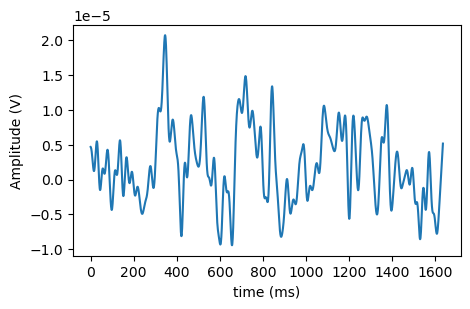

In [26]:
# ex_ts = trials[0][50,:resp_points[0]]
ex_ts = trials[0][10,:resp_points[0]]

fig = plt.figure(figsize=(5,3))
plt.plot(ex_ts)
plt.xlabel('time (ms)')
plt.ylabel('Amplitude (V)')

In [27]:
# Find the best tau computing the minimum of the mutual information
best_tau = MI_for_delay(ex_ts)
# Find the best m with false nearest neighbor algorithm
_, m = FNN_n(ex_ts, best_tau)
print(best_tau, m)

24 3


In [28]:
# Time-delay embedding
m = 3
ts_td = td_embedding(ex_ts, m, best_tau)
ts_td = ts_td.transpose((1,0))

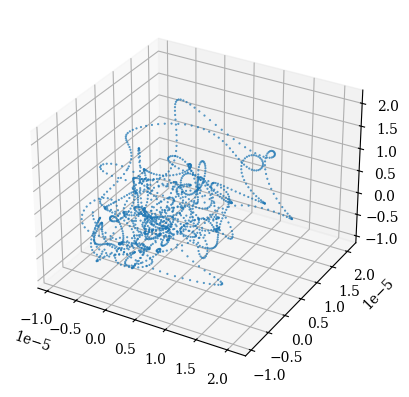

In [31]:
# Plot the embedded time series 
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(ts_td[0,:], ts_td[1,:], ts_td[2,:], s=0.3, alpha=0.8)

In [47]:
%%time
# Compute the distance matrix
distance_matrix_ = distance_matrix(ts_td, m, m) # Compute the distance matrix

CPU times: total: 7.19 s
Wall time: 7.27 s


<Axes: >

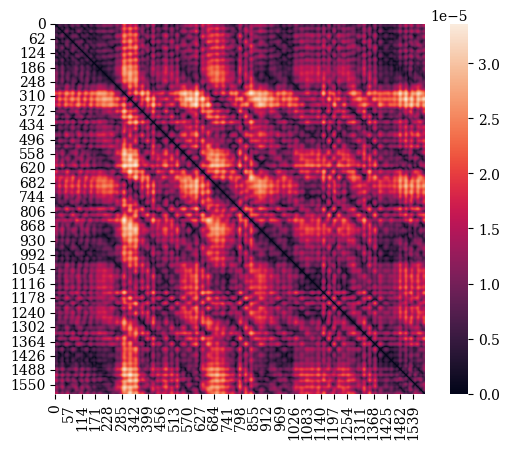

In [48]:
# Plot the distance matrix
sns.heatmap(distance_matrix_, square=True)

In [45]:
%%time
# Faster distance matrix computation
distance_matrix_ = distance_matrix_scipy(ts_td, m)

CPU times: total: 15.6 ms
Wall time: 21.2 ms


<Axes: >

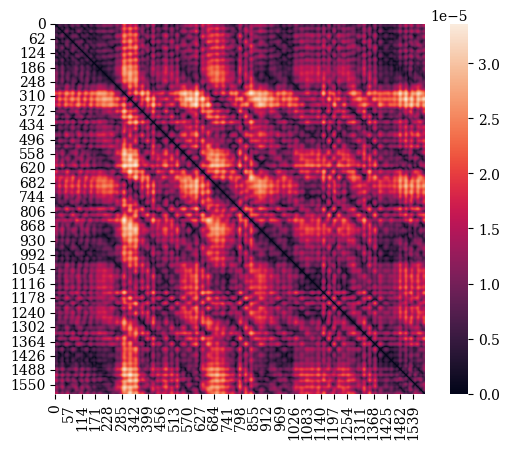

In [46]:
# Plot the distance matrix
sns.heatmap(distance_matrix_, square=True)

<>:9: SyntaxWarning: invalid escape sequence '\D'
<>:10: SyntaxWarning: invalid escape sequence '\D'
<>:9: SyntaxWarning: invalid escape sequence '\D'
<>:10: SyntaxWarning: invalid escape sequence '\D'
C:\Users\alebo\AppData\Local\Temp\ipykernel_22256\2283287301.py:9: SyntaxWarning: invalid escape sequence '\D'
  plt.xlabel('$\Delta$ t')
C:\Users\alebo\AppData\Local\Temp\ipykernel_22256\2283287301.py:10: SyntaxWarning: invalid escape sequence '\D'
  plt.ylabel('$\Delta$ r')


Text(0, 0.5, '$\\Delta$ r')

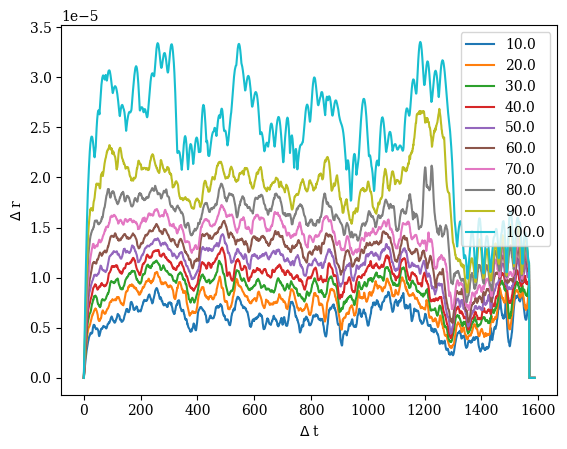

In [39]:
# Separation plot
percentiles = np.linspace(10,100,10)
sep_plt_ = sep_plt(distance_matrix_, percentiles, distance_matrix_.shape[0])

plt.figure()
for i,p in enumerate(percentiles):
    plt.plot(sep_plt_[i], label=p)
plt.legend()
plt.xlabel('$\Delta$ t')
plt.ylabel('$\Delta$ r')

In [40]:
# Compute the correlation exponent and find the first plateau to have an extimate of the Correlational dimension D_2
# Correlation exponent
min_r = np.sort(distance_matrix_[distance_matrix_!=0])[2]
rs = np.linspace(min_r,np.max(distance_matrix_),1000)
csums = []
for r in tqdm(rs):
    csums.append(corr_sum(distance_matrix_, r, 0))

n_points = 50
corr_exps = corr_exp(np.log(csums), np.log(rs), n_points, False )

x = np.log(rs)[n_points-1:]
y = corr_exps[0]
plt.plot(x,y)


plateaus = find_plateaus(corr_exps[0], tol=0.01)
for plateau in plateaus:
    plt.plot(x[plateau['start']:plateau['end']],y[plateau['start']:plateau['end']], color='red')

plt.ylabel('corr exp')
plt.xlabel('$log(r)$')

# Range of values of the first plateau
target_r = rs[plateaus[0]['start']:plateaus[0]['end']]
D_2 = plateaus[0]['value']

print(target_r.mean(), D_2)

 28%|██▊       | 280/1000 [00:48<02:04,  5.80it/s]


KeyboardInterrupt: 

<Axes: >

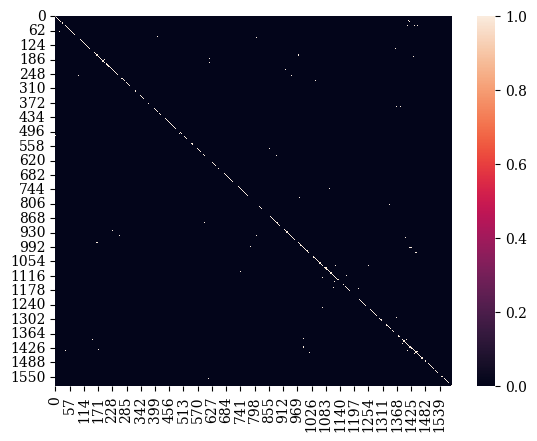

In [ ]:
# Recurrence Plot
r = np.mean(target_r)
r = target_r[-1]
r_plot = rec_plt(distance_matrix_, r, distance_matrix_.shape[0])
sns.heatmap(r_plot)


In [ ]:
# Recurrence Rate for best r
r = target_r[-1]
r_plot = rec_plt(distance_matrix_, r, distance_matrix_.shape[0])
rr = np.sum(r_plot)/(r_plot.shape[0]**2)
print('RR for r=', r, ' : ',rr)

RR for r= 8.482598730263738e-07  :  0.0023719553997927066


100%|██████████| 1000/1000 [06:40<00:00,  2.49it/s]


Text(0, 0.5, 'Recurrencce rate (%)')

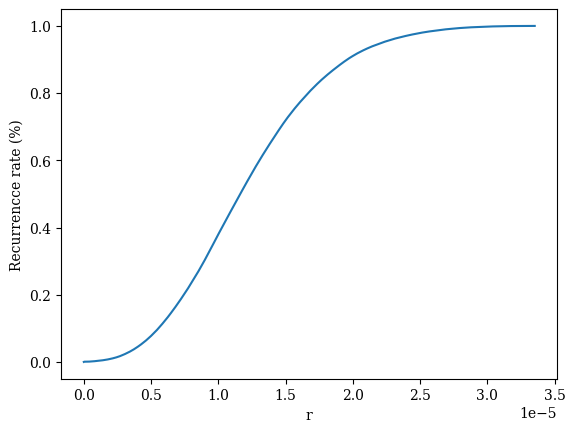

In [ ]:
# Compute Recurrence Rate (RR) for different r
RRs = []
rs = []
for r in tqdm(np.linspace(0,np.max(distance_matrix_),1000)):
    r_plot = rec_plt(distance_matrix_, r, distance_matrix_.shape[0])
    rr = np.sum(r_plot)/(r_plot.shape[0]**2)
    RRs.append(rr)
    rs.append(r)

plt.plot(rs, RRs)
plt.xlabel('r')
plt.ylabel('Recurrencce rate (%)')

In [ ]:
# Measure also Laminarity (LAM, vertical lines), Determinism (DET, diagonal lines)
# and Entropy from the recurrence plot (but i always have to explore it for different r)


In [ ]:
# Determinism for the best r
min_length = 3
r = target_r[-1]
r_plot = rec_plt(distance_matrix_, r, distance_matrix_.shape[0])
det = determinism(r_plot, min_length=min_length)
print('Det for r=', r, ' : ',det)

Det for r= 8.482598730263738e-07  :  0.9747170964825337


In [ ]:
# Determinism with respect to r
min_length = 3
Dets = []
rs = []
min_distance = np.sort(distance_matrix_[distance_matrix_!=0].flatten())[0]
flag = False
for r in tqdm(np.linspace(min_distance,np.max(distance_matrix_),100)):
    r_plot = rec_plt(distance_matrix_, r, distance_matrix_.shape[0])
    # compute det only if there's at least one diagonal line of minimum length
    if not flag:
        if min_length_exists(r_plot, min_length=min_length):
            flag = True
        else:
            Dets.append(0)
            rs.append(round(r/np.max(distance_matrix_),4))
    else:
        det = determinism(r_plot, min_length=min_length)
        Dets.append(det)
        rs.append(round(r/np.max(distance_matrix_),4))

100%|██████████| 100/100 [01:55<00:00,  1.16s/it]


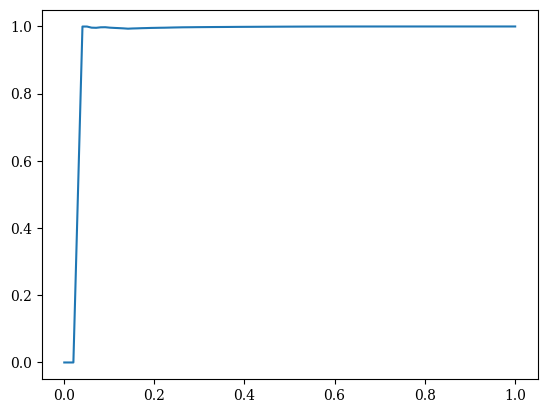

In [ ]:
plt.plot(rs, Dets)

In [ ]:
# Determinism fast 
# Compute a r x min_length matrix
n_r = 60 # Number of r positions
n_l = 60   # Number of mininmal lenghts
dets_matrix = np.zeros((n_l, n_r))
min_distance = np.sort(distance_matrix_[distance_matrix_!=0].flatten())[0]
max_distance = ((np.max(distance_matrix_) - min_distance )/3)*2
y_ticks = []
for m_i, min_length in enumerate(range(2, 600, int(600/n_l))): # Loop over minimal length
    print(min_length)
    y_ticks.append(min_length)
    flag = True
    x_ticks = []
    for r_i, r in tqdm(enumerate(np.linspace(min_distance,max_distance, n_r))): # Loop over r
        x_ticks.append(r)
        r_plot = rec_plt(distance_matrix_, r, distance_matrix_.shape[0])

        det = determinism_fast(r_plot,min_length=min_length)
        dets_matrix[m_i, r_i] = det



2


60it [00:21,  2.73it/s]


12


55it [00:22,  2.45it/s]


KeyboardInterrupt: 

In [ ]:
# Compute a r x min_length matrix
n_r = 60 # Number of r positions
n_l = 60   # Number of mininmal lenghts
dets_matrix = np.zeros((n_l, n_r))
min_distance = np.sort(distance_matrix_[distance_matrix_!=0].flatten())[0]
max_distance = ((np.max(distance_matrix_) - min_distance )/3)*2
y_ticks = []
for m_i, min_length in enumerate(range(2, 600, int(600/n_l))): # Loop over minimal length
    print(min_length)
    y_ticks.append(min_length)
    flag = True
    x_ticks = []
    for r_i, r in tqdm(enumerate(np.linspace(min_distance,max_distance, n_r))): # Loop over r
        x_ticks.append(r)
        r_plot = rec_plt(distance_matrix_, r, distance_matrix_.shape[0])
        # compute det only if there's at least one diagonal line of minimum length
        if flag:
            if not min_length_exists(r_plot, min_length=min_length):
                flag = False
            else:
                det = determinism(r_plot, min_length=min_length)
                dets_matrix[m_i, r_i] = det
        if not flag:
            if min_length_exists(r_plot, min_length=min_length):
                flag = True
            else:
                dets_matrix[m_i, r_i] = 0

2


60it [01:45,  1.76s/it]


12


60it [00:57,  1.04it/s]


22


60it [00:52,  1.15it/s]


32


60it [00:47,  1.26it/s]


42


60it [00:45,  1.32it/s]


52


60it [00:43,  1.39it/s]


62


60it [00:40,  1.47it/s]


72


60it [00:39,  1.51it/s]


82


60it [00:38,  1.58it/s]


92


60it [00:36,  1.66it/s]


102


60it [00:34,  1.75it/s]


112


60it [00:33,  1.80it/s]


122


60it [00:32,  1.84it/s]


132


60it [00:32,  1.84it/s]


142


60it [00:32,  1.86it/s]


152


60it [00:31,  1.89it/s]


162


60it [00:31,  1.89it/s]


172


60it [00:30,  1.95it/s]


182


60it [00:31,  1.92it/s]


192


60it [00:30,  1.97it/s]


202


60it [00:29,  2.02it/s]


212


60it [00:29,  2.06it/s]


222


60it [00:29,  2.03it/s]


232


60it [00:28,  2.08it/s]


242


60it [00:28,  2.11it/s]


252


60it [00:28,  2.10it/s]


262


60it [00:28,  2.13it/s]


272


60it [00:28,  2.13it/s]


282


60it [00:27,  2.15it/s]


292


60it [00:27,  2.18it/s]


302


60it [00:28,  2.14it/s]


312


60it [00:28,  2.14it/s]


322


60it [00:27,  2.16it/s]


332


60it [00:27,  2.17it/s]


342


60it [00:27,  2.15it/s]


352


60it [00:27,  2.16it/s]


362


60it [00:27,  2.19it/s]


372


60it [00:27,  2.21it/s]


382


60it [00:26,  2.22it/s]


392


60it [00:26,  2.29it/s]


402


60it [00:26,  2.26it/s]


412


60it [00:26,  2.27it/s]


422


60it [00:26,  2.25it/s]


432


60it [00:26,  2.30it/s]


442


60it [00:26,  2.26it/s]


452


60it [00:26,  2.26it/s]


462


60it [00:26,  2.28it/s]


472


60it [00:25,  2.32it/s]


482


60it [00:25,  2.31it/s]


492


60it [00:26,  2.29it/s]


502


60it [00:26,  2.25it/s]


512


60it [00:26,  2.29it/s]


522


60it [00:26,  2.29it/s]


532


60it [00:25,  2.33it/s]


542


60it [00:25,  2.32it/s]


552


60it [00:25,  2.32it/s]


562


60it [00:26,  2.30it/s]


572


60it [00:26,  2.28it/s]


582


60it [00:25,  2.33it/s]


592


60it [00:25,  2.32it/s]


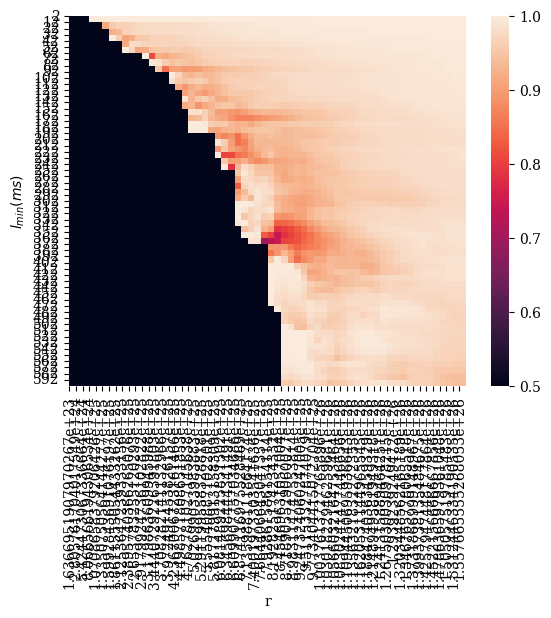

In [ ]:
fig, ax = plt.subplots(1, )
# x_ticks = [round(x/np.max(distance_matrix_), 4)for x in x_ticks]
sns.heatmap(dets_matrix, vmin=0.5, ax=ax, annot=False)
ax.set_xlabel('r')
ax.set_ylabel('$l_{min} (ms)$');
ax.set_xticks([x for x in range(n_r)]);
ax.set_yticks([y for y in range(n_l)]);
ax.set_xticklabels(x_ticks, rotation=90);
ax.set_yticklabels(y_ticks, rotation=0);

In [ ]:
# Laminarity for the best r
min_length = 3
r = target_r[-1]
r_plot = rec_plt(distance_matrix_, r, distance_matrix_.shape[0])
lam = laminarity(r_plot, min_length=min_length)
print('Det for r=', r, ' : ',lam)

Det for r= 8.482598730263738e-07  :  0.9998645867017474


In [ ]:
# Laminarity
# Compute a r x min_length matrix
n_r = 60 # Number of r positions
n_l = 60   # Number of mininmal lenghts
lams_matrix = np.zeros((n_l, n_r))
min_distance = np.sort(distance_matrix_[distance_matrix_!=0].flatten())[0]
max_distance = ((np.max(distance_matrix_) - min_distance )/3)*2
y_ticks = []
for m_i, min_length in enumerate(range(2, 600, int(600/n_l))): # Loop over minimal length
    print(min_length)
    y_ticks.append(min_length)
    flag = True
    x_ticks = []
    for r_i, r in tqdm(enumerate(np.linspace(min_distance,max_distance, n_r))): # Loop over r
        x_ticks.append(r)
        r_plot = rec_plt(distance_matrix_, r, distance_matrix_.shape[0])
        # compute det only if there's at least one diagonal line of minimum length
        if flag:
            if not min_length_exists_lam(r_plot, min_length=min_length):
                flag = False
            else:
                lam = laminarity(r_plot, min_length=min_length)
                lams_matrix[m_i, r_i] = lam
        if not flag:
            if min_length_exists_lam(r_plot, min_length=min_length):
                flag = True
            else:
                lams_matrix[m_i, r_i] = 0

2


60it [01:44,  1.73s/it]


12


60it [01:20,  1.34s/it]


22


60it [01:06,  1.11s/it]


32


60it [02:12,  2.20s/it]


42


60it [02:52,  2.88s/it]


52


60it [01:27,  1.45s/it]


62


60it [00:59,  1.01it/s]


72


60it [00:52,  1.15it/s]


82


60it [00:44,  1.34it/s]


92


60it [00:43,  1.38it/s]


102


60it [00:41,  1.43it/s]


112


60it [00:40,  1.49it/s]


122


60it [00:44,  1.35it/s]


132


60it [00:48,  1.23it/s]


142


60it [00:49,  1.21it/s]


152


60it [00:49,  1.22it/s]


162


60it [00:55,  1.08it/s]


172


60it [00:39,  1.52it/s]


182


60it [00:32,  1.83it/s]


192


60it [00:31,  1.88it/s]


202


60it [00:32,  1.86it/s]


212


60it [00:31,  1.92it/s]


222


60it [00:31,  1.92it/s]


232


60it [00:31,  1.88it/s]


242


60it [00:35,  1.68it/s]


252


60it [00:34,  1.75it/s]


262


60it [00:34,  1.74it/s]


272


60it [00:34,  1.75it/s]


282


60it [00:32,  1.83it/s]


292


60it [00:31,  1.89it/s]


302


60it [00:31,  1.92it/s]


312


60it [00:30,  1.94it/s]


322


60it [00:29,  2.04it/s]


332


60it [00:29,  2.01it/s]


342


60it [00:29,  2.02it/s]


352


60it [00:29,  2.01it/s]


362


60it [00:29,  2.05it/s]


372


60it [00:29,  2.03it/s]


382


60it [00:29,  2.06it/s]


392


60it [00:28,  2.09it/s]


402


60it [00:29,  2.04it/s]


412


60it [00:28,  2.09it/s]


422


60it [00:28,  2.12it/s]


432


60it [00:28,  2.09it/s]


442


60it [00:28,  2.12it/s]


452


60it [00:28,  2.13it/s]


462


60it [00:28,  2.12it/s]


472


60it [00:28,  2.09it/s]


482


60it [00:28,  2.12it/s]


492


60it [00:28,  2.13it/s]


502


60it [00:28,  2.12it/s]


512


60it [00:28,  2.11it/s]


522


60it [00:28,  2.09it/s]


532


60it [00:28,  2.11it/s]


542


60it [00:28,  2.13it/s]


552


60it [00:28,  2.10it/s]


562


60it [00:28,  2.13it/s]


572


60it [00:28,  2.14it/s]


582


60it [00:28,  2.14it/s]


592


60it [00:28,  2.14it/s]


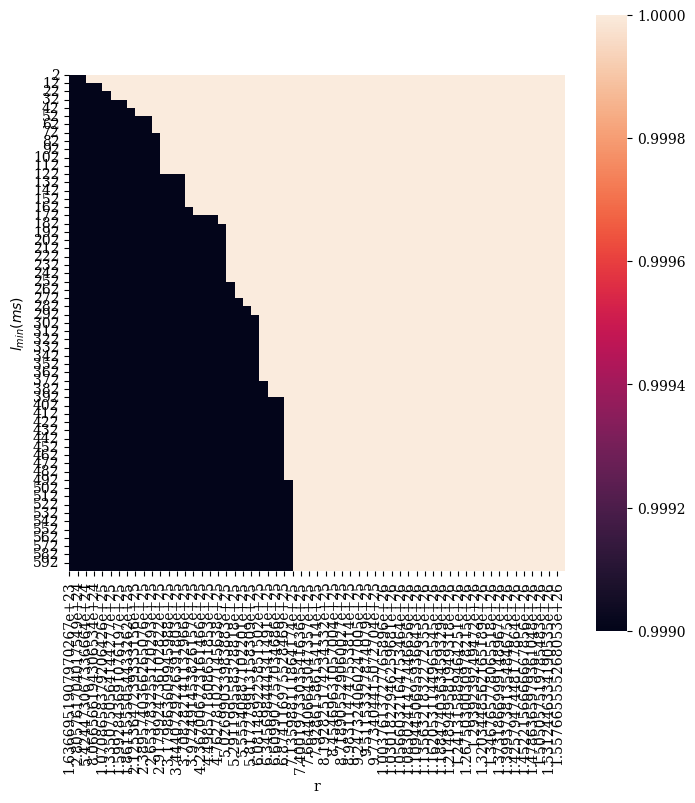

In [ ]:
fig, ax = plt.subplots(1, figsize=(8,8))
x_ticks = [round(x/np.max(distance_matrix_), 4)for x in x_ticks]
sns.heatmap(lams_matrix, vmin=0.999, ax=ax, annot=False, square=True)
ax.set_xlabel('r')
ax.set_ylabel('$l_{min} (ms)$');
ax.set_xticks([x for x in range(n_r)]);
ax.set_yticks([y for y in range(n_l)]);
ax.set_xticklabels(x_ticks, rotation=90);
ax.set_yticklabels(y_ticks, rotation=0);

100%|██████████| 52/52 [00:06<00:00,  7.97it/s]


Text(0, 0.5, 'Determinism')

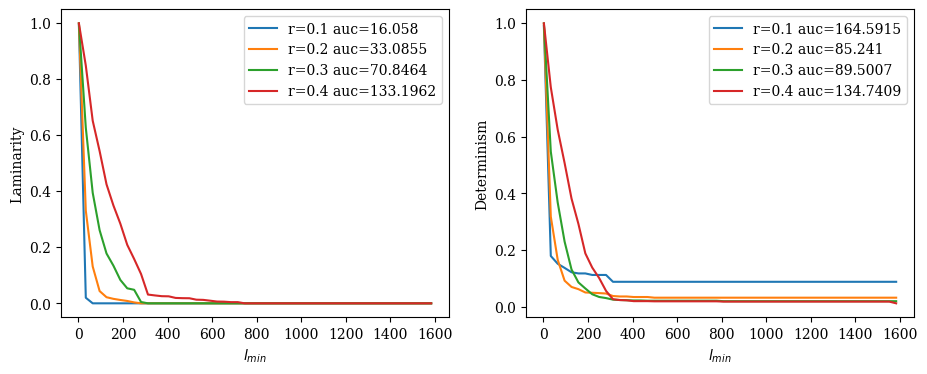

In [44]:
# Laminarity and Determinism for fixed r and with respect to varying minimum length
n_l=50
fig, axs = plt.subplots(1,2, figsize=(11,4)) # Two axis, one for laminarity and one for determinism
rs_perc = [0.1,0.2,0.3,0.4] # r values, percentage with respect to the diameter of the phase space
max_distance = distance_matrix_.max() 
for r_perc in rs_perc:
    r = max_distance*r_perc
    r_plot = rec_plt(distance_matrix_, r, distance_matrix_.shape[0])
    M = r_plot
    dets = [] # determinis at fixed r
    lams = [] # laminarity at fixed r
    ls = []
    for l in tqdm(range(2, M.shape[0]-1, int((M.shape[0]-1)/n_l))):
        det = determinism_fast(r_plot, min_length=l)
        lam = laminarity_fast(r_plot, min_length=l)
        dets.append(det)
        lams.append(lam)
        ls.append(l)
    auc_dets = round(np.trapezoid(dets, ls), 4) # area under the curve
    auc_lams = round(np.trapezoid(lams, ls), 4) # area under the curve

    axs[0].plot(ls, lams, label='r='+str(r/max_distance)+' auc='+str(auc_lams))
    axs[1].plot(ls, dets, label='r='+str(r/max_distance)+' auc='+str(auc_dets))
axs[0].legend()
axs[0].set_xlabel('$l_{min}$')
axs[0].set_ylabel('Laminarity')
axs[1].legend()
axs[1].set_xlabel('$l_{min}$')
axs[1].set_ylabel('Determinism')

In [626]:
# Max distance
n_r = 150 # Number of r positions
L_maxs = []
min_distance = np.sort(distance_matrix_[distance_matrix_!=0].flatten())[0]
max_distance = ((np.max(distance_matrix_) - min_distance )/3)*2
max_distance = np.max(distance_matrix_) 

flag = True
x_ticks = []
for r_i, r in tqdm(enumerate(np.linspace(min_distance,max_distance, n_r))): # Loop over r
    x_ticks.append(r)
    r_plot = rec_plt(distance_matrix_, r, distance_matrix_.shape[0])
    # compute det only if there's at least one diagonal line of minimum length
    if flag:
        if not min_length_exists(r_plot, min_length=2):
            flag = False
        else:
            L = L_max(r_plot)
            L_maxs.append(L)
    if not flag:
        if min_length_exists(r_plot, min_length=2):
            flag = True
        else:
            L_maxs.append(0)


150it [00:56,  2.67it/s]


Text(0, 0.5, 'L_max')

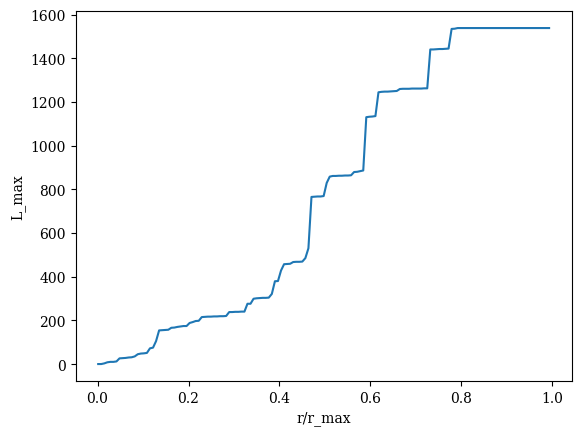

In [648]:
# x_ticks = [round(x/np.max(distance_matrix_), 4)for x in x_ticks]
L_maxs_inv = [1/l for l in L_maxs if l!=0]
plt.plot(x_ticks[:-1], L_maxs)
plt.xlabel('r/r_max')
plt.ylabel('L_max')

In [605]:
# Average diagonal length
n_r = 150 # Number of r positions
L_av = []
min_distance = np.sort(distance_matrix_[distance_matrix_!=0].flatten())[0]
# max_distance = ((np.max(distance_matrix_) - min_distance )/3)*2
max_distance = np.max(distance_matrix_) 


x_ticks = []
for r_i, r in tqdm(enumerate(np.linspace(min_distance,max_distance, n_r))): # Loop over r
    x_ticks.append(r)
    r_plot = rec_plt(distance_matrix_, r, distance_matrix_.shape[0])
    L = L_average(r_plot)
    L_av.append(L)

0it [00:00, ?it/s]c:\Users\alebo\miniconda3\envs\eeg\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\alebo\miniconda3\envs\eeg\Lib\site-packages\numpy\_core\_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
150it [00:56,  2.64it/s]


Text(0, 0.5, 'L_average')

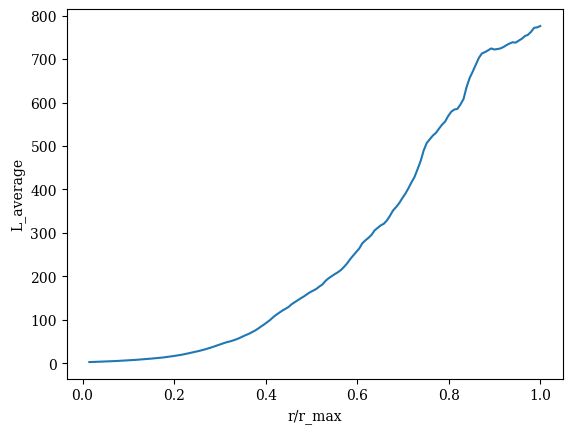

In [639]:
# x_ticks = [round(x/np.max(distance_matrix_), 4)for x in x_ticks]
plt.plot(x_ticks, L_av)
plt.xlabel('r/r_max')
plt.ylabel('L_average')

In [642]:
# Average vertical lines length (Trapping Time)
n_r = 150 # Number of r positions
TTs = []
min_distance = np.sort(distance_matrix_[distance_matrix_!=0].flatten())[0]
# max_distance = ((np.max(distance_matrix_) - min_distance )/3)*2
max_distance = np.max(distance_matrix_) 


x_ticks = []
for r_i, r in tqdm(enumerate(np.linspace(min_distance,max_distance, n_r))): # Loop over r
    x_ticks.append(r)
    r_plot = rec_plt(distance_matrix_, r, distance_matrix_.shape[0])
    TT = trapping_time(r_plot)
    TTs.append(TT)

0it [00:00, ?it/s]c:\Users\alebo\miniconda3\envs\eeg\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\alebo\miniconda3\envs\eeg\Lib\site-packages\numpy\_core\_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
150it [00:55,  2.69it/s]


Text(0, 0.5, 'Trapping Time')

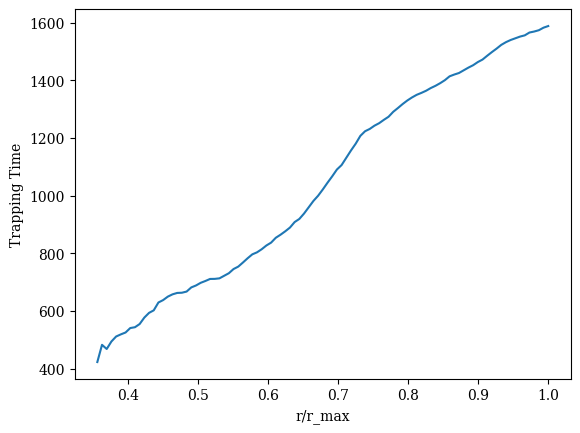

In [643]:
x_ticks = [round(x/np.max(distance_matrix_), 4)for x in x_ticks]
plt.plot(x_ticks, TTs)
plt.xlabel('r/r_max')
plt.ylabel('Trapping Time')

In [748]:
# Entropy for fixed r
r = ((max_distance-min_distance)/4)*3
r = target_r[-1]
r_plot = rec_plt(distance_matrix_, r, distance_matrix_.shape[0])
S = diagonal_line_entropy(r_plot)
S

2.018307396061364

In [670]:
# Entropy
n_r = 150 # Number of r positions
Ss = []
min_distance = np.sort(distance_matrix_[distance_matrix_!=0].flatten())[0]
# max_distance = ((np.max(distance_matrix_) - min_distance )/3)*2
max_distance = np.max(distance_matrix_) 


x_ticks = []
for r_i, r in tqdm(enumerate(np.linspace(min_distance,max_distance, n_r))): # Loop over r
    x_ticks.append(r)
    r_plot = rec_plt(distance_matrix_, r, distance_matrix_.shape[0])
    if flag:
        if not min_length_exists(r_plot, min_length=2):
            flag = False
        else:
            S = diagonal_line_entropy(r_plot)
            Ss.append(S)
    if not flag:
        if min_length_exists(r_plot, min_length=2):
            flag = True
        else:
            Ss.append(0)

150it [01:03,  2.38it/s]


Text(0, 0.5, 'Entropy')

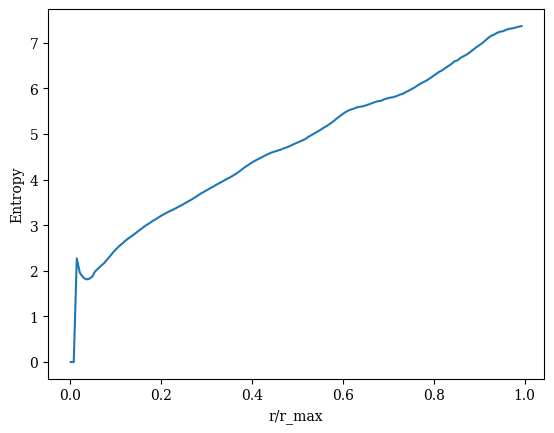

In [ ]:
# x_ticks = [round(x/np.max(distance_matrix_), 4)for x in x_ticks]
plt.plot(x_ticks[:-1], Ss)
plt.xlabel('r/r_max')
plt.ylabel('Entropy')

## All the RQA measures together

In [40]:
rs_perc = [0.1,0.2,0.3,0.4] # r values, percentage with respect to the diameter of the phase space
max_distance = distance_matrix_.max() 
r = max_distance*rs_perc[0]
r_plot = rec_plt(distance_matrix_, r, distance_matrix_.shape[0])
rqa_res = rqa_all_metrics_auc_rr_theiler(r_plot, lmin_stop=r_plot.shape[0]-1, theiler=5)


In [41]:
rqa_res

{'n': 1589,
 'theiler': 5,
 'lmins': array([   2,    3,    4, ..., 1585, 1586, 1587], shape=(1586,)),
 'rr': 0.023518507883637383,
 'rr_num': 58972,
 'rr_den': 2507472,
 'det_curve': array([0.98768907, 0.93295123, 0.82958014, ..., 0.        , 0.        ,
        0.        ], shape=(1586,)),
 'lam_curve': array([0.99008004, 0.96352506, 0.91306044, ..., 0.        , 0.        ,
        0.        ], shape=(1586,)),
 'det_auc': 7.604507223767212,
 'lam_auc': 9.01374381062199,
 'det_auc_norm': 0.004797796355689093,
 'lam_auc_norm': 0.005686904612379805,
 'lmax': 89,
 'lmean': 6.132189032545698,
 'entropy': 2.3331546223233492,
 'tt': 7.54695178642582}

In [51]:
# Compute the RQA measures over all the electrodes and plot over the scalp
rs_perc = [0.1,0.2,0.3,0.4] # r values, percentage with respect to the diameter of the phase space
m = 3
ex_trial = trials[0][:,:resp_points[0]]
res_dict = {'rr':[], 'det_auc_norm':[], 'lam_auc_norm':[], 'l_max':[], 'l_mean':[], 'entropy':[], 'tt':[]}
for ch_idx,ch in tqdm(enumerate(ch_names)):
    ex_ts = ex_trial[ch_idx]
    best_tau = MI_for_delay(ex_ts)
    ts_td = td_embedding(ex_ts, m, best_tau).transpose((1,0))
    distance_matrix_ = distance_matrix_scipy(ts_td, m)
    max_distance = distance_matrix_.max() 
    r = max_distance*rs_perc[0]
    r_plot = rec_plt(distance_matrix_, r, distance_matrix_.shape[0])
    rqa_res = rqa_all_metrics_auc_rr_theiler(r_plot, lmin_stop=r_plot.shape[0]-1, theiler=5)

    for key in rqa_res.keys():
        if key in res_dict.keys():
            res_dict[key].append(rqa_res[key])


61it [00:20,  2.99it/s]


In [57]:
np.array(res_dict['entropy'])[np.newaxis,:].shape

(1, 61)

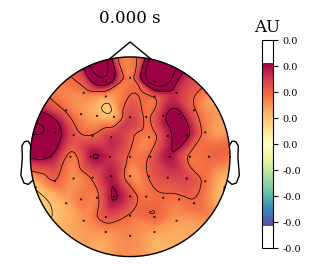

In [73]:
info.set_montage(montage)
values = np.asarray(res_dict['det_auc_norm'])
v = values[np.isfinite(values)]
vmin, vmax = np.percentile(v, [5, 95])
# For a diverging map centered at 0 (often best for signed effects):
lim = np.max(np.abs([vmin, vmax]))
vmin, vmax = -lim, lim
evoked_array = mne.EvokedArray(data=values[:,np.newaxis], info=info) # size: n_ch x time
fig = evoked_array.plot_topomap(times = [0], scalings=1,size=2, nrows=1, cmap="Spectral_r", show=False,
                                    sphere=(0, 0, 0, 0.12), vlim=(vmin, vmax))


# Faster correlation dimension computation ($D_2$)

In [74]:
import numpy as np

def prepare_pair_distances(dist_matrix: np.ndarray, theiler: int = 0) -> np.ndarray:
    """
    Extract valid pair distances (i>j), optionally excluding |i-j| <= theiler.
    Returns a 1D array of distances.
    """
    D = np.asarray(dist_matrix)
    if D.ndim != 2 or D.shape[0] != D.shape[1]:
        raise ValueError("dist_matrix must be square (N,N).")

    N = D.shape[0]

    # indices for lower triangle (i>j)
    ii, jj = np.tril_indices(N, k=-1)

    if theiler > 0:
        keep = (ii - jj) > theiler
        ii, jj = ii[keep], jj[keep]

    d = D[ii, jj]
    # optional: drop zeros if they are self-distances or duplicates
    # (you already exclude diagonal; zeros may still exist if identical points)
    d = d[d > 0]

    return d


def corr_sum_many_rs(dist_matrix: np.ndarray, rs: np.ndarray, theiler: int = 0) -> np.ndarray:
    """
    Compute correlation sum C(r) for many r values efficiently.

    C(r) = (#pairs with distance < r) / (#valid pairs)
    """
    rs = np.asarray(rs, dtype=float)
    if np.any(rs <= 0):
        raise ValueError("All r must be > 0 to take logs later.")

    d = prepare_pair_distances(dist_matrix, theiler=theiler)
    if d.size == 0:
        raise ValueError("No valid pairs after Theiler exclusion / filtering.")

    d_sorted = np.sort(d)
    counts = np.searchsorted(d_sorted, rs, side="left")
    C = counts / d_sorted.size
    return C

from scipy.ndimage import gaussian_filter1d

def rolling_linreg_slope(x: np.ndarray, y: np.ndarray, win: int) -> np.ndarray:
    """
    Rolling linear regression slope of y ~ a*x + b over a centered window of length win.
    Returns an array of length len(x)-win+1 aligned to window centers.
    """
    x = np.asarray(x, dtype=float)
    y = np.asarray(y, dtype=float)
    if win < 2 or win > x.size:
        raise ValueError("win must be in [2, len(x)].")

    w = np.ones(win)

    Sx  = np.convolve(x, w, mode="valid")
    Sy  = np.convolve(y, w, mode="valid")
    Sxx = np.convolve(x*x, w, mode="valid")
    Sxy = np.convolve(x*y, w, mode="valid")

    denom = win * Sxx - Sx*Sx
    # avoid division by zero
    denom = np.where(denom == 0, np.nan, denom)

    slope = (win * Sxy - Sx*Sy) / denom
    return slope


def corr_exponent_from_C(rs: np.ndarray,
                         Cs: np.ndarray,
                         win: int = 50,
                         smooth_sigma: float | None = None):
    """
    Compute local correlation exponent via rolling regression on log-log curve.
    Returns: log_r_center, exponent
    """
    rs = np.asarray(rs, float)
    Cs = np.asarray(Cs, float)

    # avoid log(0)
    eps = np.finfo(float).tiny
    log_r = np.log(rs)
    log_C = np.log(np.maximum(Cs, eps))

    expn = rolling_linreg_slope(log_r, log_C, win=win)

    # x-values aligned to window centers
    centers = np.arange(win//2, log_r.size - (win - 1)//2)
    log_r_center = log_r[centers]

    if smooth_sigma is not None and smooth_sigma > 0:
        expn = gaussian_filter1d(expn, sigma=smooth_sigma)

    return log_r_center, expn



First plateau D2 ~ 2.4034642745493815


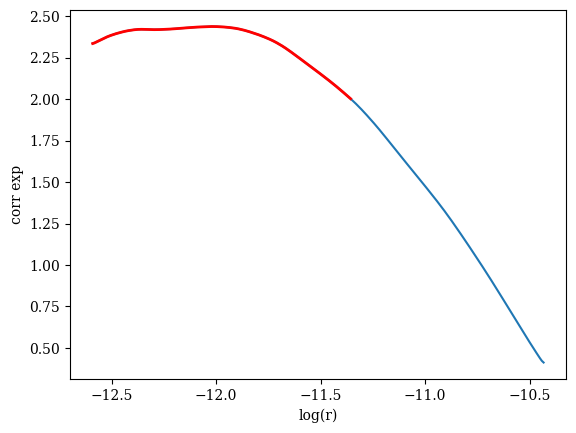

In [75]:
import numpy as np
import matplotlib.pyplot as plt

# 1) Radii: use logspace on distance scale
d_all = prepare_pair_distances(distance_matrix_, theiler=0)
min_r = np.percentile(d_all, 1)   # more robust than "3rd smallest"
max_r = np.percentile(d_all, 99)  # avoid extreme tail
rs = np.logspace(np.log10(min_r), np.log10(max_r), 300)

# 2) C(r) efficiently
Cs = corr_sum_many_rs(distance_matrix_, rs, theiler=0)

# 3) Local exponent
win = 50
log_r_center, expn = corr_exponent_from_C(rs, Cs, win=win, smooth_sigma=1.0)

plt.plot(log_r_center, expn)
plt.ylabel("corr exp")
plt.xlabel("log(r)")

# 4) Plateau detection (your function)
plateaus = find_plateaus(expn, tol=0.01, min_len=20)

for p in plateaus:
    plt.plot(log_r_center[p["start"]:p["end"]+1],
             expn[p["start"]:p["end"]+1],
             color="red", linewidth=2)

if plateaus:
    p0 = plateaus[0]
    # map plateau indices back to r-range (centered coordinates)
    r_center = np.exp(log_r_center)
    target_r = r_center[p0["start"]:p0["end"]+1]
    D2 = p0["value"]
    print("First plateau D2 ~", D2)
else:
    print("No plateau found with current tol/min_len.")
